In [1]:
from fastplotlib import Plot, GridPlot
import numpy as np
import random

RFBOutputContext()


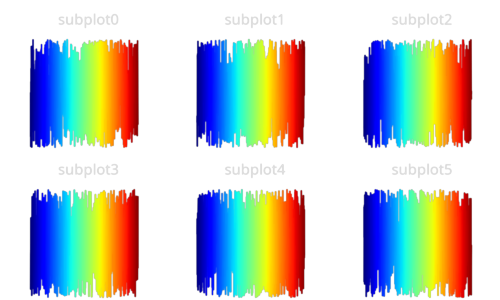

JupyterWgpuCanvas()

In [2]:
# Static Buffer w/ Full Buffer Replacement

## Set grid_plot attributes
grid_shape = (2, 3)

controllers = [
    [0, 3, 1],  
    [2, 2, 3]
]

names = [
    ["subplot0", "subplot1", "subplot2"],
    ["subplot3", "subplot4", "subplot5"]
]

# Create the grid plot
grid_plot = GridPlot(
    shape=grid_shape,
    controllers=controllers,
    names=names
)

image_graphics = list()

# Make a random line for each subplot
for subplot in grid_plot:
    xs = np.linspace(0, 1000, 1000)
    ys = random.sample(range(0,1000), 1000)
    data = np.dstack([xs, ys])[0]
    ig = subplot.add_line(data=data, cmap='jet', name="image")
    image_graphics.append(ig)
    

# Define a function to update the image graphics 
# with new randomly generated data
def set_random_frame():
    for ig in image_graphics:
        ys = random.sample(range(0,1000), 1000)
        new_data = np.dstack([xs, ys])[0]
        ig.data = new_data
# add the animation
grid_plot.add_animations(set_random_frame)
grid_plot.show()

RFBOutputContext()


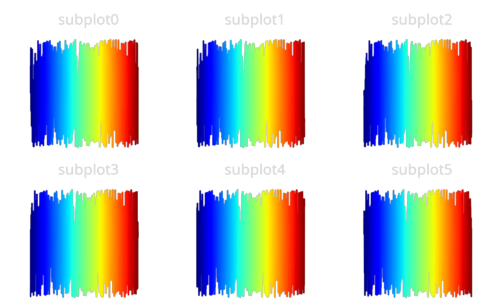

JupyterWgpuCanvas()

In [3]:
# Static Buffer w/ Partial Replacement (Rolling Buffer)
## Simple Indexing

# Set window size
window_length = 10

## Set grid_plot attributes
grid_shape = (2, 3)

controllers = [
    [0, 3, 1],  
    [2, 2, 3]
]

names = [
    ["subplot0", "subplot1", "subplot2"],
    ["subplot3", "subplot4", "subplot5"]
]

# Create the grid plot
grid_plot = GridPlot(
    shape=grid_shape,
    controllers=controllers,
    names=names
)

image_graphics = list()

# Make a random line for each subplot
for subplot in grid_plot:
    xs = np.linspace(0, 1000, 1000)
    ys = random.sample(range(0,1000), 1000)
    data = np.dstack([xs, ys])[0]
    ig = subplot.add_line(data=data, cmap='jet', name="image")
    image_graphics.append(ig)

# Define a function to update the image graphics 
# with new randomly generated data
def set_random_frame():
    for ig in image_graphics:
        ys = random.sample(range(0,1000), window_length)
        new_data_points = np.dstack([xs[-window_length:], ys])[0]
        data[:-window_length] = data[window_length:] - [window_length,0]
        data[-window_length:] = new_data_points
        ig.data = data
# add the animation
grid_plot.add_animations(set_random_frame)
grid_plot.show()

In [ ]:
from multiprocessing.shared_memory import SharedMemory
from multiprocessing.managers import SharedMemoryManager
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import current_process, cpu_count, Process, Lock
from datetime import datetime
import numpy as np
import pandas as pd
import tracemalloc
import time
from fastplotlib import Plot, GridPlot
import random

def create_gridplot():
    # Set window size
    window_length = 10

    ## Set grid_plot attributes
    grid_shape = (2, 3)

    controllers = [
        [0, 3, 1],  
        [2, 2, 3]
    ]

    names = [
        ["subplot0", "subplot1", "subplot2"],
        ["subplot3", "subplot4", "subplot5"]
    ]

    # Create the grid plot
    grid_plot = GridPlot(
        shape=grid_shape,
        controllers=controllers,
        names=names
    )
    return grid_plot, window_length

def create_shared_block(grid_plot):
    xs = np.linspace(0,1000,1000)
    ys = np.ones(shape=(6,1000), dtype=np.int64)
    image_graphics = list()
    for i, subplot in enumerate(grid_plot):
        ys[i] =  random.sample(range(0,1000), 1000)
        data = np.dstack([xs, ys[i]])[0]
        ig = subplot.add_line(data=data, cmap='jet', name="image")
        image_graphics.append(ig)
        
    return xs, ys, image_graphics

def stream_data(shm_name, shape, dtype):
    while True:
        existing_shm = SharedMemory(name=shm_name)
        ys_shared = np.recarray(shape=shape, dtype=dtype, buf=existing_shm.buf)
        lock.acquire()
        ys_shared[:]+=1
        lock.release()
        existing_shm.close()

def visualise_data(shm_name, shape, dtype):
    while True:
        existing_shm = SharedMemory(name=shm_name)
        ys_shared = np.recarray(shape=shape, dtype=dtype, buf=existing_shm.buf)
        lock.acquire()
        print(ys_shared[0])
        lock.release()
        existing_shm.close()

if __name__ == "__main__":
    lock = Lock()
    grid_plot, window_length = create_gridplot()
    print(grid_plot)
    xs, ys, image_graphics = create_shared_block(grid_plot)
    shape, dtype = ys.shape, ys.dtype
    grid_plot.show()
    
    # Start tracking memory usage
#     tracemalloc.start()
#     start_time = time.time()
    with SharedMemoryManager() as smm:
        # Create a shared memory of size np_arry.nbytes
        shm = smm.SharedMemory(ys.nbytes)
        ys_shared = np.recarray(shape=shape, dtype=dtype, buf=shm.buf)
        np.copyto(ys_shared, ys)
        
        existing_shm = SharedMemory(name=shm.name)
        
        p1 = Process(target=stream_data, args=(shm.name, shape, dtype, ))
        p2 = Process(target=visualise_data, args=(shm.name, shape, dtype, ))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
    # Check memory usage
#     current, peak = tracemalloc.get_traced_memory()
#     print(f"Current memory usage {current/1e6}MB; Peak: {peak/1e6}MB")
#     print(f'Time elapsed: {time.time()-start_time:.2f}s')
#     tracemalloc.stop()